In [1]:
import bw2io as bi
import bw2data as bd
import bw2calc as bc
import bw2analyzer as ba
import bw_temporalis as bwt

In [2]:
import numpy as np
import pandas as pd
import seaborn as sb

In [3]:
import os
from typing import Optional
from pathlib import Path

# Setting the project to the team one on the server

In [4]:
def change_base_directory(base_dir: Path) -> None: 
    assert isinstance(base_dir, Path) and base_dir.is_dir() and os.access(base_dir, os.W_OK) 
    
    bd.projects._base_data_dir = base_dir
    bd.projects.db.change_path(base_dir / "projects.db") 
    bd.projects.set_current("default", update=False) 

In [5]:
tictac_team_dir = Path("/srv/teams/tictac_team") 
change_base_directory(tictac_team_dir) 

bd.projects.set_current("tictac_premise")

In [6]:
bd.projects.current

'tictac_premise'

In [7]:
bd.databases

Databases dictionary with 0 objects

# Setting the project to one having ecoinvent, from the notebook

In [4]:
bi.restore_project_directory("/srv/data/ecoinvent-3.9-cutoff.tar.gz", project_name="tictac3")

Restoring project backup archive - this could take a few minutes...


ValueError: Project tictac3 already exists

In [5]:
bd.projects

Brightway2 projects manager with 8 objects:
	Temporalis example project
	bw_temporalis example
	default
	ecoinvent-3.9-cutoff
	ecoinvent=3.9-cutoff
	premise_ei39
	tictac2
	tictac3
Use `projects.report()` to get a report on all projects.

In [6]:
bd.projects.set_current('tictac3')

In [7]:
# bd.projects.migrate_project_25()

In [8]:
bd.databases

Databases dictionary with 4 object(s):
	biosphere3
	ecoinvent-3.9-cutoff
	wind-example
	wind_db

In [9]:
del bd.databases['wind-example']
ei = bd.Database('ecoinvent-3.9-cutoff')

# Temporal distribution for wind electricity (onshore) in `Europe`, corresponding to `remind SSP2 - 1150` IAM scenario

### Values 

In [10]:
a = np.array([0.79, 1.57, 3.6, 6.03, 8.73, 10.66, 11.27, 11.31])
a = a/np.sum(a) # normalizing the trend in Exajoules to get an actual TD

## Absolute TD

In [66]:
d = np.array([str(2010+k*10)+"-01-01" for k in range(8)])
d = np.array(d,dtype=np.datetime64)
print(d)

['2010-01-01' '2020-01-01' '2030-01-01' '2040-01-01' '2050-01-01'
 '2060-01-01' '2070-01-01' '2080-01-01']


<Axes: xlabel='Date', ylabel='Amount'>

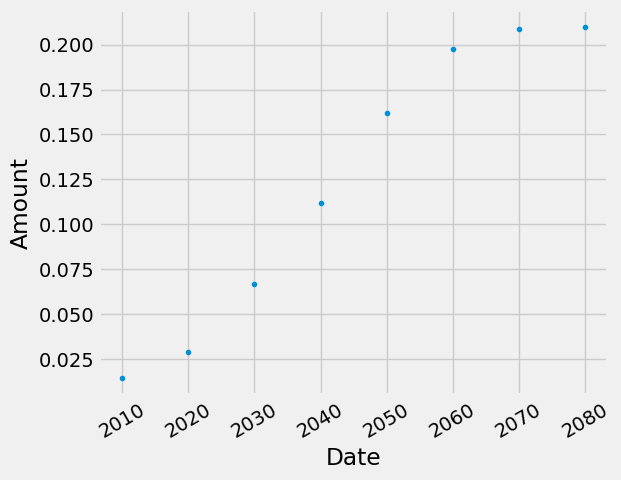

In [67]:
inc_wind_turbine_energy_absolute = bwt.TemporalDistribution(
    date=d,
    amount=a
)
inc_wind_turbine_energy_absolute.graph()

## Relative TD

In [13]:
delta = np.array([np.timedelta64(10*(k+1), 'Y') for k in range(8)])
print(delta)

[10 20 30 40 50 60 70 80]


<Axes: xlabel='Time (seconds)', ylabel='Amount'>

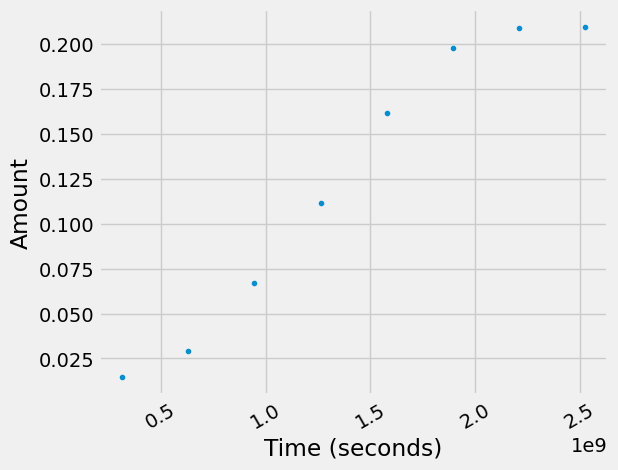

In [14]:
inc_wind_turbine_energy_relative = bwt.TemporalDistribution(
    date=delta,
    amount=a
)
inc_wind_turbine_energy_relative.graph()

# New background activities for the wind turbine

In [15]:
# retrieve activity
wind_cons = bd.Database("ecoinvent-3.9-cutoff").get(name="wind turbine construction, 2MW, onshore", location="GLO")
wind_cons['code']

del bd.databases['wind_db']
bd.Database("wind_db").register()
wind_cons.copy(database="wind_db")

'wind turbine construction, 2MW, onshore' (unit, GLO, None)

In [16]:
wind=bd.Database("wind_db")
len(wind)

1

In [17]:
wind_cons = bd.Database("wind_db").get(name="wind turbine construction, 2MW, onshore", location="GLO")
ex = [e for e in wind_cons.exchanges() if "electricity" in e.input["name"]][0]

# change amount
ex["amount"] = 0
ex.save()

In [18]:
wind_cons = bd.Database("wind_db").get(name="wind turbine construction, 2MW, onshore", location="GLO") #without electricity
ex = [e for e in wind_cons.exchanges() if "electricity" in e.input["name"]]
print(ex)

[Exchange: 0 kilowatt hour 'market group for electricity, medium voltage' (kilowatt hour, GLO, None) to 'wind turbine construction, 2MW, onshore' (unit, GLO, None)>]


In [19]:
wind_elec = bd.Database("ecoinvent-3.9-cutoff").get(name="market group for electricity, medium voltage", location="RER")
wind_elec

'market group for electricity, medium voltage' (kilowatt hour, RER, None)

# The wind turbine system 

In [20]:
del bd.databases['wind-example']

KeyError: 'wind-example'

<Axes: xlabel='Time (seconds)', ylabel='Amount'>

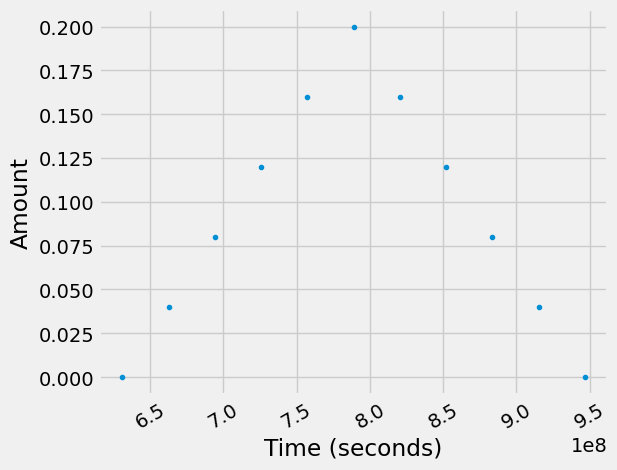

In [49]:
bwt.easy_timedelta_distribution(
                    start=10,
                    end=20,
                    resolution="Y",  # M for months, Y for years, etc.
                    steps=11,
                    kind = 'triangular',
                    param = 15
                ).graph()

In [68]:
LT = 20 # 20 years lifetime of a wind turbine
generated_electricity_over_lifetime = 0.2*(2000*365*24)*LT  # Amount of electricity generated by a wind turbine over its lifetime in kWh, 20% of capacity factor
share_of_wind_in_electricity_mix = 0.50

bd.Database('wind-example').write({
    ('wind-example', 'electricity-mix+wind'): {
        'name': 'Electricity mix',
        'unit': 'kilowatt hour',
        'exchanges': [
            {
                'input': ('wind-example', 'electricity-production-wind'),
                'amount': share_of_wind_in_electricity_mix,
                'type': 'technosphere',
                #'temporal_distribution' : TD_constant_increase_wind_share,
            },
            {
                'input': (wind_elec),
                'amount': 1-share_of_wind_in_electricity_mix,
                'type': 'technosphere',
            },
        ]
    },
    ('wind-example', 'electricity-production-wind'): {
        'name': 'Electricity production, wind',
        'unit': 'kilowatt hour',
        'exchanges': [
            {
                'input': ('wind-example', 'electricity-production-wind'),
                'amount': 1,
                'type': 'production',
            },
            {
                'input': ('wind-example', 'operational-wind-turbine'),
                'amount': 1/generated_electricity_over_lifetime,
                'type': 'technosphere',
                'temporal_distribution' : inc_wind_turbine_energy_relative, #we would prefer to use the absolute TD, but for some reason the graph reversal isn't working with it...
            },
        ]
    },
        ('wind-example', 'operational-wind-turbine'): {
        'name': "End-of-life, wind turbine",
        'unit': 'unit',
        'exchanges': [
            {
                'input': ('wind-example', 'wind-turbine-construction'),
                'amount': 1,
                'type': 'technosphere',
                'temporal_distribution': bwt.easy_timedelta_distribution(
                    start=-4,
                    end=0,
                    resolution="Y",  # M for months, Y for years, etc.
                    steps=5,
                    kind = 'triangular',
                    param = -1
                ),
            },
            {
                'input': ('wind-example', 'eol-wind'),
                'amount': 1,
                'type': 'technosphere',
                'temporal_distribution': bwt.easy_timedelta_distribution(
                    start=10,
                    end=20,
                    resolution="Y",  # M for months, Y for years, etc.
                    steps=11,
                    kind = 'triangular',
                    param = 15
                )
            },
        ]
    },
    ('wind-example', 'wind-turbine-construction'): {
        'name': 'Wind turbine construction',
        'unit': 'unit',
        'exchanges': [
            {
                'input': ('wind-example', 'wind-turbine-construction'),
                'amount': 1,
                'type': 'production',
            },
            {
                'input': ('wind-example', 'electricity-mix+wind'),
                'amount': 0.75*1.443e7,
                'type': 'technosphere',
            },
            {
                'input': wind_cons,
                'amount': 0.75,
                'type': 'technosphere',
            },
        ]
    },
    ('wind-example', 'eol-wind'): {
        'name': "End-of-life, wind turbine",
        'unit': 'unit',
        'exchanges': [
            {
                'input': ('wind-example', 'eol-wind'),
                'amount': 1,
                'type': 'production',
            },
            {
                'input': ('wind-example', 'electricity-mix+wind'),
                'amount': 0.25*1.443e5,
                'type': 'technosphere',
            },
            {
                'input': wind_cons,
                'amount': 0.25,
                'type': 'technosphere',
            },
        ]
    },
})

Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 5/5 [00:00<00:00, 40721.40it/s]

Vacuuming database 


In [69]:
lca = bc.LCA({('wind-example', 'electricity-production-wind'): 1}, ('IPCC 2021 no LT', 'climate change no LT', 'global warming potential (GWP100) no LT'))
lca.lci()
lca.lcia()
lca.score

0.04689971080853378

In [70]:
top_wind_proc = ba.ContributionAnalysis().annotated_top_processes(lca)[:10]
top_wind_proc

[(0.0033388510224970644,
  0.0028170441659112447,
  'electricity production, lignite' (kilowatt hour, DE, None)),
 (0.0020648984336291013,
  0.0024319244005687178,
  'pig iron production' (kilogram, RoW, None)),
 (0.0019196896056442282,
  0.0019249281770696383,
  'heat and power co-generation, hard coal' (kilowatt hour, PL, None)),
 (0.001472380886073288,
  0.0030799861063356792,
  'electricity production, natural gas, conventional power plant' (kilowatt hour, GB, None)),
 (0.0013407465283681954,
  0.0011186013886293035,
  'electricity production, hard coal' (kilowatt hour, UA, None)),
 (0.001266647637175243,
  7.259974299132435e-05,
  'natural gas venting from petroleum/natural gas production' (cubic meter, GLO, None)),
 (0.0011703990212173318,
  0.0010444037452340198,
  'heat and power co-generation, lignite' (kilowatt hour, PL, None)),
 (0.001112127453690432,
  0.00015637182678687788,
  'nylon 6-6 production, glass-filled' (kilogram, RoW, None)),
 (0.0011001438541413677,
  0.0013601

In [71]:
tlca = bwt.TemporalisLCA(lca, starting_datetime=np.datetime64(40, 'Y'))

Starting graph traversal
Calculation count: 1074


In [72]:
tl = tlca.build_timeline()

In [73]:
df = tl.build_dataframe()
df = tl.add_metadata_to_dataframe(['ecoinvent-3.9-cutoff'])
df

,date,amount,flow,activity,activity_location,activity_name,activity_unit,flow_location,flow_name,flow_unit
0,2016-12-31 16:44:24,1.862012e-13,1999,24594,CH,"market for electricity, medium voltage",kilowatt hour,NaN,NaN,NaN
1,2016-12-31 16:44:24,1.212498e-07,1168,19329,DK,"heat and power co-generation, hard coal",kilowatt hour,NaN,NaN,NaN
2,2016-12-31 16:44:24,4.651686e-12,4688,24028,FR,"market for electricity, high voltage",kilowatt hour,NaN,NaN,NaN
3,2016-12-31 16:44:24,9.938415e-07,1168,18601,IT,"electricity production, hard coal",kilowatt hour,NaN,NaN,NaN
4,2016-12-31 16:44:24,9.521525e-12,4688,19387,DK,"market for electricity, high voltage",kilowatt hour,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
26177,2244-12-31 23:42:00,8.774564e-13,4688,21342,DE,"market for electricity, high voltage",kilowatt hour,NaN,NaN,NaN
26178,2246-01-01 05:31:12,7.521055e-13,4688,21342,DE,"market for electricity, high voltage",kilowatt hour,NaN,NaN,NaN
26179,2246-01-01 05:31:12,1.732649e-14,1999,6339,DE,"market for electricity, medium voltage",kilowatt hour,NaN,NaN,NaN
26180,2247-01-01 11:20:24,3.760528e-13,4688,21342,DE,"market for electricity, high voltage",kilowatt hour,NaN,NaN,NaN


In [79]:
df2  = bd.Database('wind-example').nodes_to_dataframe()
df2

,code,database,id,name,unit
0,electricity-mix+wind,wind-example,25966,Electricity mix,kilowatt hour
3,electricity-production-wind,wind-example,25967,"Electricity production, wind",kilowatt hour
2,operational-wind-turbine,wind-example,25968,"End-of-life, wind turbine",unit
4,eol-wind,wind-example,25970,"End-of-life, wind turbine",unit
1,wind-turbine-construction,wind-example,25969,Wind turbine construction,unit


In [75]:
df.merge(df.rename(columns={'id' : 'activity'}), on='activity')

,date_x,amount_x,flow_x,activity,activity_location_x,activity_name_x,activity_unit_x,flow_location_x,flow_name_x,flow_unit_x,date_y,amount_y,flow_y,activity_location_y,activity_name_y,activity_unit_y,flow_location_y,flow_name_y,flow_unit_y
0,2016-12-31 16:44:24,1.862012e-13,1999,24594,CH,"market for electricity, medium voltage",kilowatt hour,NaN,NaN,NaN,2016-12-31 16:44:24,1.862012e-13,1999,CH,"market for electricity, medium voltage",kilowatt hour,NaN,NaN,NaN
1,2016-12-31 16:44:24,1.862012e-13,1999,24594,CH,"market for electricity, medium voltage",kilowatt hour,NaN,NaN,NaN,2017-12-31 22:33:36,3.724024e-13,1999,CH,"market for electricity, medium voltage",kilowatt hour,NaN,NaN,NaN
2,2016-12-31 16:44:24,1.862012e-13,1999,24594,CH,"market for electricity, medium voltage",kilowatt hour,NaN,NaN,NaN,2019-01-01 04:22:48,5.586036e-13,1999,CH,"market for electricity, medium voltage",kilowatt hour,NaN,NaN,NaN
3,2016-12-31 16:44:24,1.862012e-13,1999,24594,CH,"market for electricity, medium voltage",kilowatt hour,NaN,NaN,NaN,2027-01-01 02:56:24,3.700454e-13,1999,CH,"market for electricity, medium voltage",kilowatt hour,NaN,NaN,NaN
4,2016-12-31 16:44:24,1.862012e-13,1999,24594,CH,"market for electricity, medium voltage",kilowatt hour,NaN,NaN,NaN,2028-01-01 08:45:36,7.400908e-13,1999,CH,"market for electricity, medium voltage",kilowatt hour,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362825,2088-12-31 03:46:48,3.597144e-12,1999,19389,EE,"market for electricity, medium voltage",kilowatt hour,NaN,NaN,NaN,2077-12-31 11:45:36,2.389615e-12,1999,EE,"market for electricity, medium voltage",kilowatt hour,NaN,NaN,NaN
6362826,2088-12-31 03:46:48,3.597144e-12,1999,19389,EE,"market for electricity, medium voltage",kilowatt hour,NaN,NaN,NaN,2078-12-31 17:34:48,3.584422e-12,1999,EE,"market for electricity, medium voltage",kilowatt hour,NaN,NaN,NaN
6362827,2088-12-31 03:46:48,3.597144e-12,1999,19389,EE,"market for electricity, medium voltage",kilowatt hour,NaN,NaN,NaN,2086-12-31 16:08:24,1.199048e-12,1999,EE,"market for electricity, medium voltage",kilowatt hour,NaN,NaN,NaN
6362828,2088-12-31 03:46:48,3.597144e-12,1999,19389,EE,"market for electricity, medium voltage",kilowatt hour,NaN,NaN,NaN,2087-12-31 21:57:36,2.398096e-12,1999,EE,"market for electricity, medium voltage",kilowatt hour,NaN,NaN,NaN


Text(0.5, 1.0, 'C02 emissions over time_ FU : 1 kWh produced by electricity mix')

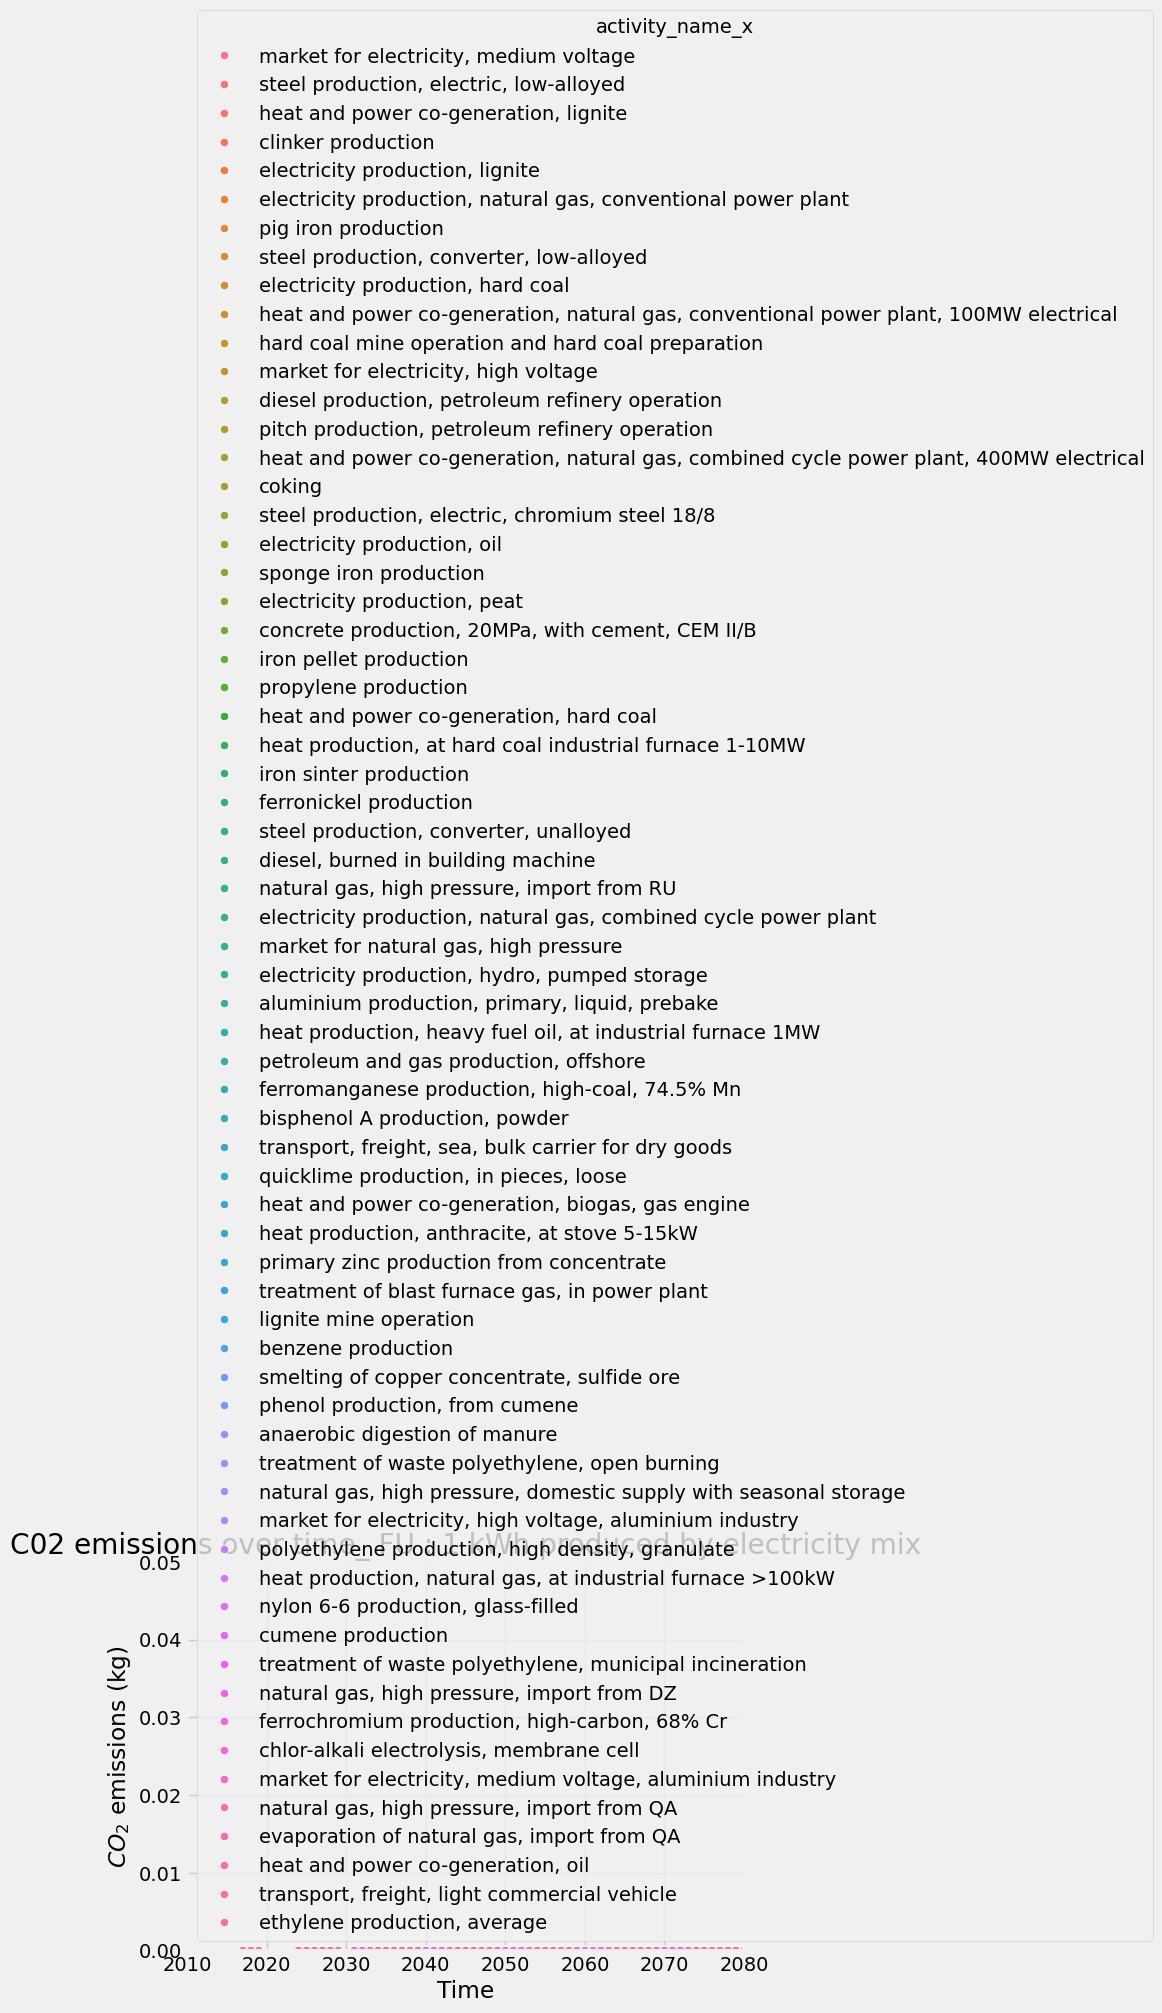

In [58]:
axes = sb.scatterplot(
    x = "date_x",
    y = 'amount_y',
    hue = 'activity_name_x',
    data = df.merge(
        df.rename(columns={'id' : 'activity'}), on='activity'
    )
)
axes.set_ylabel("$CO_{2}$ emissions (kg)")
axes.set_xlabel("Time")
axes.set_xlim(xmin=np.datetime64(40, 'Y'), xmax=np.datetime64(110, 'Y'))
axes.set_ylim(ymax=0.05)
axes.set_title("C02 emissions over time_ FU : 1 kWh produced by electricity mix") #right after being put in service

Text(0.5, 0, 'Time (years)')

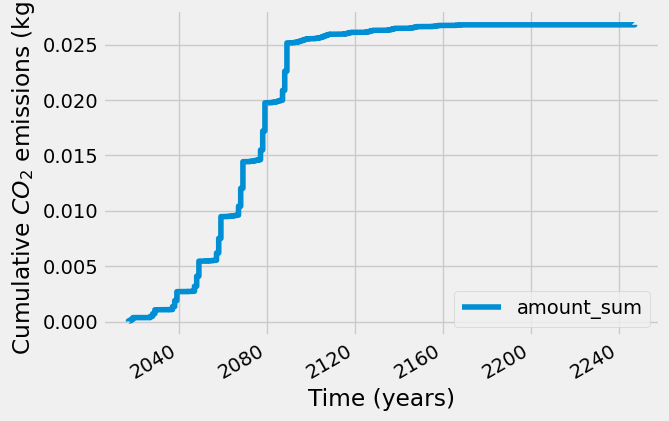

In [76]:
df["amount_sum"] = df['amount'].cumsum()
axes = df.plot(x="date", y="amount_sum")
axes.set_ylabel("Cumulative $CO_{2}$ emissions (kg)")
axes.set_xlabel("Time (years)")

# Timeline of activities

In [85]:
def build_timeline_processes(tlca, db) :
    ' take as input'
    ' - the result of the graph reversal (given by the "bwt.TemporalisLCA") '
    ' - the name of the database as str (static database, not prospective) '
    ' return a dataframe within the following columns '
    ' - date '
    ' - amount '
    ' - activity (?)'
    ' - database '
    ' - name (of activity) '
    ' - type '
    ' - unit '
    
    tl_activities= tlca.build_timeline(node_timeline=True) #creating timeline for the nodes, not the flows
    df_tl_act = tl_activities.build_dataframe() # converting the data into dataframe
    df_tl_act = df_tl_act.merge(bd.Database(db).nodes_to_dataframe().rename(columns={"id" : "activity"}), on='activity_x')
    
    del df_tl_act['flow']
    
    return df_tl_act


In [86]:
df_tl_act = build_timeline_processes(tlca, 'ecoinvent-3.9-cutoff')
df_tl_act

/opt/tljh/user/envs/autumn_school/lib/python3.11/site-packages/bw_temporalis/lca.py:135: UserWarning: This functionality is experimental, and will change.
You have been warned.
  warnings.warn(


KeyError: 'activity_x'

### Example : exchanges timeline for energy activities

In [41]:
df_tl_energy = df_tl_act[df_tl_act['unit']=='kilowatt hour']

In [42]:
df_tl_energy

,date,amount,activity,code,database,name,unit
0,2010-01-01 00:00:00,1.000000e+00,25967,electricity-production-wind,wind-example,"Electricity production, wind",kilowatt hour
1,2016-12-31 16:44:24,3.014584e-04,25967,electricity-production-wind,wind-example,"Electricity production, wind",kilowatt hour
2,2017-12-31 22:33:36,6.029168e-04,25967,electricity-production-wind,wind-example,"Electricity production, wind",kilowatt hour
3,2019-01-01 04:22:48,9.043752e-04,25967,electricity-production-wind,wind-example,"Electricity production, wind",kilowatt hour
4,2024-01-01 09:28:48,9.087717e-08,25967,electricity-production-wind,wind-example,"Electricity production, wind",kilowatt hour
...,...,...,...,...,...,...,...
835,2322-01-01 15:50:24,9.280586e-08,25966,electricity-mix+wind,wind-example,Electricity mix,kilowatt hour
836,2323-01-01 21:39:36,1.353057e-07,25966,electricity-mix+wind,wind-example,Electricity mix,kilowatt hour
837,2324-01-02 03:28:48,1.405098e-07,25966,electricity-mix+wind,wind-example,Electricity mix,kilowatt hour
838,2325-01-01 09:18:00,9.367320e-08,25966,electricity-mix+wind,wind-example,Electricity mix,kilowatt hour


In [43]:
df_tl_energy['amount']  = df_tl_energy['amount']*1000

/tmp/ipykernel_1691061/508802167.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tl_energy['amount']  = df_tl_energy['amount']*1000


In [44]:
 df_tl_energy.replace({'unit': {'kilowatt hour' :'1e-3 kilowatt hour'}})

,date,amount,activity,code,database,name,unit
0,2010-01-01 00:00:00,1000.000000,25967,electricity-production-wind,wind-example,"Electricity production, wind",1e-3 kilowatt hour
1,2016-12-31 16:44:24,0.301458,25967,electricity-production-wind,wind-example,"Electricity production, wind",1e-3 kilowatt hour
2,2017-12-31 22:33:36,0.602917,25967,electricity-production-wind,wind-example,"Electricity production, wind",1e-3 kilowatt hour
3,2019-01-01 04:22:48,0.904375,25967,electricity-production-wind,wind-example,"Electricity production, wind",1e-3 kilowatt hour
4,2024-01-01 09:28:48,0.000091,25967,electricity-production-wind,wind-example,"Electricity production, wind",1e-3 kilowatt hour
...,...,...,...,...,...,...,...
835,2322-01-01 15:50:24,0.000093,25966,electricity-mix+wind,wind-example,Electricity mix,1e-3 kilowatt hour
836,2323-01-01 21:39:36,0.000135,25966,electricity-mix+wind,wind-example,Electricity mix,1e-3 kilowatt hour
837,2324-01-02 03:28:48,0.000141,25966,electricity-mix+wind,wind-example,Electricity mix,1e-3 kilowatt hour
838,2325-01-01 09:18:00,0.000094,25966,electricity-mix+wind,wind-example,Electricity mix,1e-3 kilowatt hour


(-0.1, 1.0)

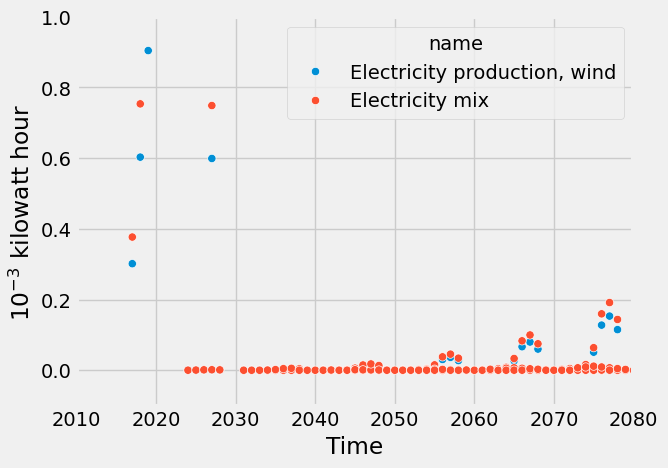

In [45]:
axes = sb.scatterplot(
    x = "date",
    y = 'amount',
    hue = 'name',
    data = df_tl_energy,
)
axes.set_ylabel("$10^{-3}$ kilowatt hour")
axes.set_xlabel("Time")
axes.set_xlim(xmin=np.datetime64(40, 'Y') ,xmax=np.datetime64(110, 'Y'))
axes.set_ylim(ymax=1, ymin=-0.1)
# axes.set_title("C02 emissions over time_ FU : 1 kWh produced by electricity mix") #right after being put in service

# Wind turbine system w/ some ei process

In [33]:
ei.search('market group electricity medium voltage RER')

['market group for electricity, medium voltage' (kilowatt hour, RER, None),
 'market for electricity, medium voltage, aluminium industry' (kilowatt hour, IAI Area, Russia & RER w/o EU27 & EFTA, None)]

In [35]:
act = bd.get_node(name="market group for electricity, medium voltage", location='RER')

In [36]:
act['code']

'17c9d0c2c72446bf59393f60c096a588'

In [67]:
del bd.databases['wind-example']

In [69]:
generated_electricity_over_lifetime = 4.38e9 / 1e3 # Amount of electricity generated by a wind turbine over its lifetime in kWh
share_of_wind_in_electricity_mix = 0.8
LT = 25 # 25 years lifetime of a wind turbine

bd.Database('wind-example').write({
    ('wind-example', "CO2"): {
        "type": "emission",
        "name": "carbon dioxide",
        "unit": "kilogram",
    },
    ('wind-example', "coal"): {
        "type": "emission",
        "name": "coal",
        "unit": "kilogram",
    },
    ('wind-example', 'electricity-mix'): {
        'name': 'Electricity mix',
        'unit': 'kilowatt hour',
        'exchanges': [
            {
                'input': ('wind-example', 'electricity-production-wind'),
                'amount': share_of_wind_in_electricity_mix,
                'type': 'technosphere',
            },
            {
                'input': ('wind-example', 'electricity-production-coal'),
                'amount': 1-share_of_wind_in_electricity_mix,
                'type': 'technosphere',
            },
        ]
    },
    ('wind-example', 'electricity-production-coal'): {
        'name': 'Electricity production, coal',
        'unit': 'kilowatt hour',
        'exchanges': [
            {
                'input': ('wind-example', 'coal'),
                'amount': 1,
                'type': 'biosphere',
            },
            {
                'input': ('wind-example', 'CO2'),
                'amount': 0.9,
                'type': 'biosphere',
            },
        ]
    },
    ('wind-example', 'electricity-production-wind'): {
        'name': 'Electricity production, wind',
        'unit': 'kilowatt hour',
        'exchanges': [
            {
                'input': ('wind-example', 'electricity-production-wind'),
                'amount': 1,
                'type': 'production',
            },
            {
                'input': ('wind-example', 'operational-wind-turbine'),
                'amount': 1/generated_electricity_over_lifetime,
                'type': 'technosphere',
                'temporal_distribution' : inc_wind_turbine_energy_relative, #we would prefer to use the absolute TD, but for some reason the graph reversal isn't working with it...
            },
            # maybe add maintenance, oil changes, ...
        ]
    },
        ('wind-example', 'operational-wind-turbine'): {
        'name': "End-of-life, wind turbine",
        'unit': 'unit',
        'exchanges': [
            {
                'input': ('wind-example', 'wind-turbine-construction'),
                'amount': 1,
                'type': 'technosphere',
                'temporal_distribution': bwt.easy_timedelta_distribution(
                    start=-1,
                    end=1,
                    resolution="Y",  # M for months, Y for years, etc.
                    steps=3,
                    # kind = '',
                    # param = 0
                ),
            },
            {
                'input': ('wind-example', 'eol-wind'),
                'amount': 1,
                'type': 'technosphere',
                'temporal_distribution': bwt.easy_timedelta_distribution(
                    start=20,
                    end=30,
                    resolution="Y",  # M for months, Y for years, etc.
                    steps=11,
                    kind = 'normal',
                    param = 0.1
                )
            },
            # CO2 emissions corresponding to maintenance
            # {
            #     'input': ('wind-example', 'CO2'),
            #     'amount': 100,
            #     'type': 'biosphere',
            # }
        ]
    },
    ('wind-example', 'wind-turbine-construction'): {
        'name': 'Wind turbine construction',
        'unit': 'unit',
        'exchanges': [
            {
                'input': ('wind-example', 'wind-turbine-construction'),
                'amount': 1,
                'type': 'production',
            },
            {
                'input': ('ecoinvent-3.9-cutoff', act['code']),
                'amount': 2e5,
                'type': 'technosphere',
            },
            {
                'input': ('wind-example', 'CO2'),
                'amount': 1e6,
                'type': 'biosphere',
            } #taking into account CO2 of machine and materials, not just operational energy
        ]
    },
    ('wind-example', 'eol-wind'): {
        'name': "End-of-life, wind turbine",
        'unit': 'unit',
        'exchanges': [
            {
                'input': ('wind-example', 'eol-wind'),
                'amount': 1,
                'type': 'production',
            },
            {
                'input': ('wind-example', 'CO2'),
                'amount': 1e5,
                'type': 'biosphere',
            }, #taking into account CO2 of machines and materials, not just operational energy
            {
                'input' : ('ecoinvent-3.9-cutoff', act['code']),
                'amount': 1e5,
                'type': 'technosphere',
            }
        ]
    },
})

Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 8/8 [00:00<00:00, 117734.85it/s]

Vacuuming database 


In [70]:
lca = bc.LCA({('wind-example', 'electricity-production-wind'): 1}, ("GWP", "wind-example"))
lca.lci()
lca.lcia()
lca.score

0.25114154738048455

In [71]:
tlca = bwt.TemporalisLCA(lca, starting_datetime=np.datetime64(40, 'Y'))

Starting graph traversal
Calculation count: 3


In [72]:
tl = tlca.build_timeline()

In [73]:
df = tl.build_dataframe()
df = tl.add_metadata_to_dataframe(['wind-example'])

In [74]:
bd.get_activity(id=25972)

'End-of-life, wind turbine' (unit, None, None)

In [75]:
df2  = bd.Database('wind-example').nodes_to_dataframe()

Text(0.5, 1.0, 'C02 emissions over time_ FU : 1 kWh produced by electricity mix')

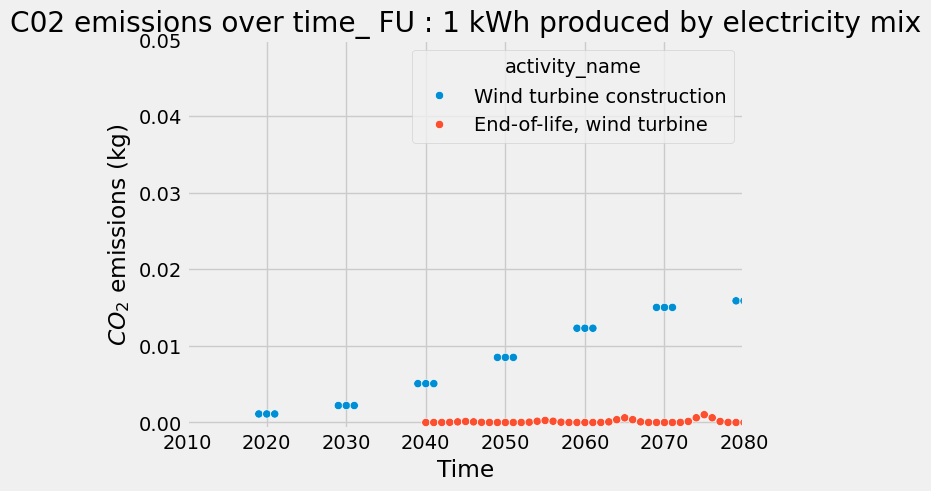

In [76]:
axes = sb.scatterplot(
    x = "date",
    y = 'amount',
    hue = 'activity_name',
    data = df.merge(
        df2.rename(columns={'id' : 'activity'}), on='activity'
    )
)
axes.set_ylabel("$CO_{2}$ emissions (kg)")
axes.set_xlabel("Time")
axes.set_xlim(xmin=np.datetime64(40, 'Y'), xmax=np.datetime64(110, 'Y'))
axes.set_ylim(ymax=0.05)
axes.set_title("C02 emissions over time_ FU : 1 kWh produced by electricity mix") #right after being put in service

In [77]:
df_tl_energy_w_ei = build_timeline_processes(tlca, 'wind-example')
df_tl_energy_w_ei

/opt/tljh/user/envs/autumn_school/lib/python3.11/site-packages/bw_temporalis/lca.py:135: UserWarning: This functionality is experimental, and will change.
You have been warned.
  warnings.warn(


,date,amount,activity,code,database,name,type,unit
0,2010-01-01 00:00:00,1.000000e+00,25969,electricity-production-wind,wind-example,"Electricity production, wind",NaN,kilowatt hour
1,2019-01-01 04:22:48,1.114191e-09,25971,wind-turbine-construction,wind-example,Wind turbine construction,NaN,unit
2,2020-01-01 10:12:00,1.114191e-09,25971,wind-turbine-construction,wind-example,Wind turbine construction,NaN,unit
3,2020-12-31 16:01:12,1.114191e-09,25971,wind-turbine-construction,wind-example,Wind turbine construction,NaN,unit
4,2028-12-31 14:34:48,2.214279e-09,25971,wind-turbine-construction,wind-example,Wind turbine construction,NaN,unit
...,...,...,...,...,...,...,...,...
109,2116-01-01 16:55:12,1.157922e-08,25972,eol-wind,wind-example,"End-of-life, wind turbine",NaN,unit
110,2116-12-31 22:44:24,2.583674e-09,25972,eol-wind,wind-example,"End-of-life, wind turbine",NaN,unit
111,2118-01-01 04:33:36,2.120808e-10,25972,eol-wind,wind-example,"End-of-life, wind turbine",NaN,unit
112,2119-01-01 10:22:48,6.404287e-12,25972,eol-wind,wind-example,"End-of-life, wind turbine",NaN,unit


In [78]:
df_tl_energy_w_ei['amount']  = df_tl_energy['amount']*1000

In [79]:
 df_tl_energy_w_ei.replace({'unit': {'kilowatt hour' :'1e-3 kilowatt hour'}})

,date,amount,activity,code,database,name,type,unit
0,2010-01-01 00:00:00,1000000.000000,25969,electricity-production-wind,wind-example,"Electricity production, wind",NaN,1e-3 kilowatt hour
1,2019-01-01 04:22:48,178.270616,25971,wind-turbine-construction,wind-example,Wind turbine construction,NaN,unit
2,2020-01-01 10:12:00,178.270616,25971,wind-turbine-construction,wind-example,Wind turbine construction,NaN,unit
3,2020-12-31 16:01:12,178.270616,25971,wind-turbine-construction,wind-example,Wind turbine construction,NaN,unit
4,2028-12-31 14:34:48,0.031780,25971,wind-turbine-construction,wind-example,Wind turbine construction,NaN,unit
...,...,...,...,...,...,...,...,...
109,2116-01-01 16:55:12,0.163080,25972,eol-wind,wind-example,"End-of-life, wind turbine",NaN,unit
110,2116-12-31 22:44:24,0.000866,25972,eol-wind,wind-example,"End-of-life, wind turbine",NaN,unit
111,2118-01-01 04:33:36,0.004846,25972,eol-wind,wind-example,"End-of-life, wind turbine",NaN,unit
112,2119-01-01 10:22:48,2405.525022,25972,eol-wind,wind-example,"End-of-life, wind turbine",NaN,unit


(-0.1, 1.0)

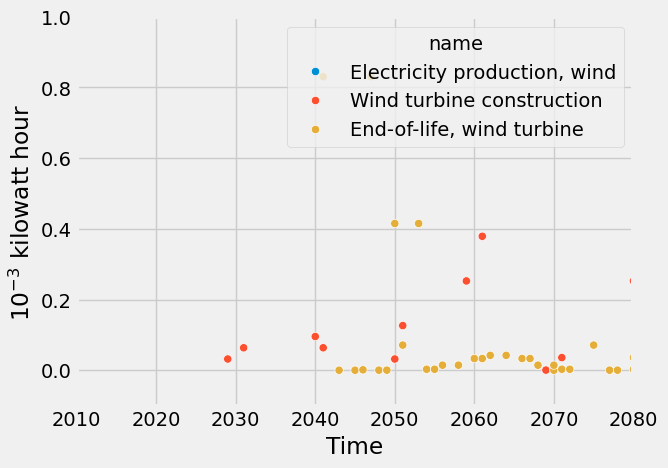

In [80]:
axes = sb.scatterplot(
    x = "date",
    y = 'amount',
    hue = 'name',
    data = df_tl_energy_w_ei,
)
axes.set_ylabel("$10^{-3}$ kilowatt hour")
axes.set_xlabel("Time")
axes.set_xlim(xmin=np.datetime64(40, 'Y') ,xmax=np.datetime64(110, 'Y'))
axes.set_ylim(ymax=1, ymin=-0.1)
# axes.set_title("C02 emissions over time_ FU : 1 kWh produced by electricity mix") #right after being put in service